In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mm_env import SimpleEnv
import random

/opt/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Random Strategy

In [2]:
#env = SimpleEnv(debug=True, dp=0.2, min_dp=4, std=0.2, mu=0.01, T=1000, lambda_neg=50, lambda_pos=50, kappa=0.02)
#env = SimpleEnv(debug=True, T=86400, lambda_neg=15, lambda_pos=10, kappa=10)
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = env.action_space.sample()
    print(env.t, action)
    state, action_reward, done = env.step(np.array(action))
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

0 [3 2]
1 [2 4]
2 [1 4]
3 [3 0]
4 [3 4]
5 [3 4]
6 [0 3]
7 [1 4]
8 [0 2]
9 [3 4]
10 [0 2]
11 [0 1]
12 [2 4]
13 [0 4]
14 [0 2]
15 [2 3]
16 [1 2]
17 [1 2]
18 [4 3]
19 [0 3]
20 [4 1]
21 [0 2]
22 [0 3]
23 [0 4]
24 [4 1]
25 [3 0]
26 [0 0]
27 [0 3]
28 [1 4]
29 [1 1]
30 [1 1]
31 [1 4]
32 [1 3]
33 [2 3]
34 [3 2]
35 [4 0]
36 [0 2]
37 [3 1]
38 [4 1]
39 [2 3]
40 [1 0]
41 [4 3]
42 [4 2]
43 [1 2]
44 [2 1]
45 [0 1]
46 [1 2]
47 [2 3]
48 [3 3]
49 [2 3]
50 [3 0]
51 [3 1]
52 [0 2]
53 [0 1]
54 [1 3]
55 [4 2]
56 [2 2]
57 [3 0]
58 [1 3]
59 [4 4]
60 [3 4]
61 [2 1]
62 [0 4]
63 [2 1]
64 [2 3]
65 [1 4]
66 [0 4]
67 [2 3]
68 [1 2]
69 [4 4]
70 [1 4]
71 [1 4]
72 [1 0]
73 [4 3]
74 [4 4]
75 [1 1]
76 [0 2]
77 [1 3]
78 [3 3]
79 [3 1]
80 [1 3]
81 [4 1]
82 [4 2]
83 [2 3]
84 [3 3]
85 [0 0]
86 [3 4]
87 [4 2]
88 [4 1]
89 [1 1]
90 [0 2]
91 [1 1]
92 [3 1]
93 [0 2]
94 [2 2]
95 [1 2]
96 [4 4]
97 [4 1]
98 [0 2]
99 [3 0]


In [3]:
env.render()

--------------------
End of t = 100
Current mid price: 83.69
Current held volume: 0
Current held value: 0.0
Current cash process: 54.03
Current value process: 54.03
--------------------



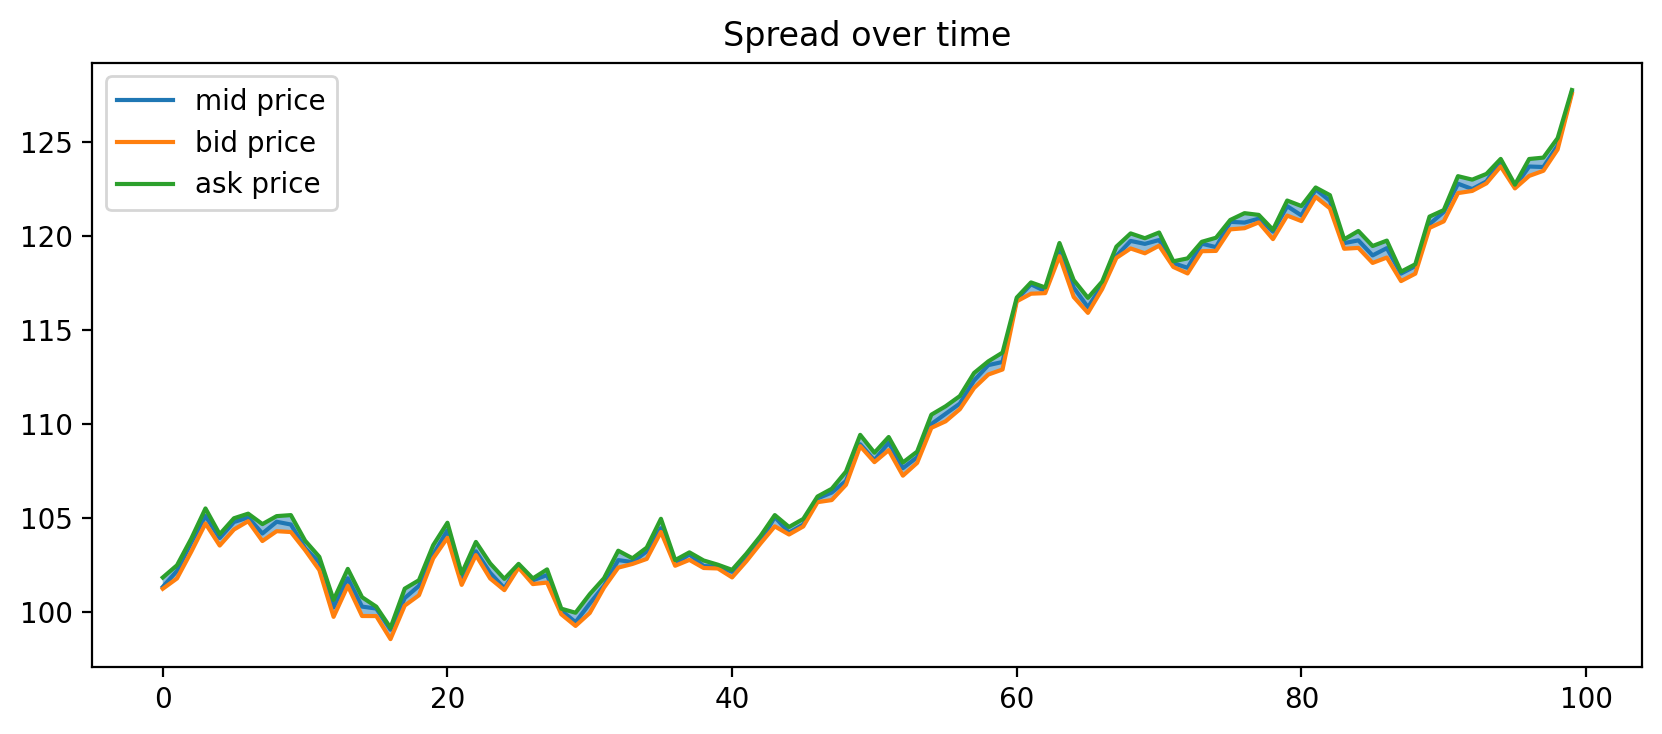

In [13]:
plt.figure(figsize=(10,4), dpi=200)
plt.plot(mid_price, label='mid price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='bid price')
plt.plot(ask_price, label='ask price')
plt.legend()
plt.title('Spread over time')
plt.show()

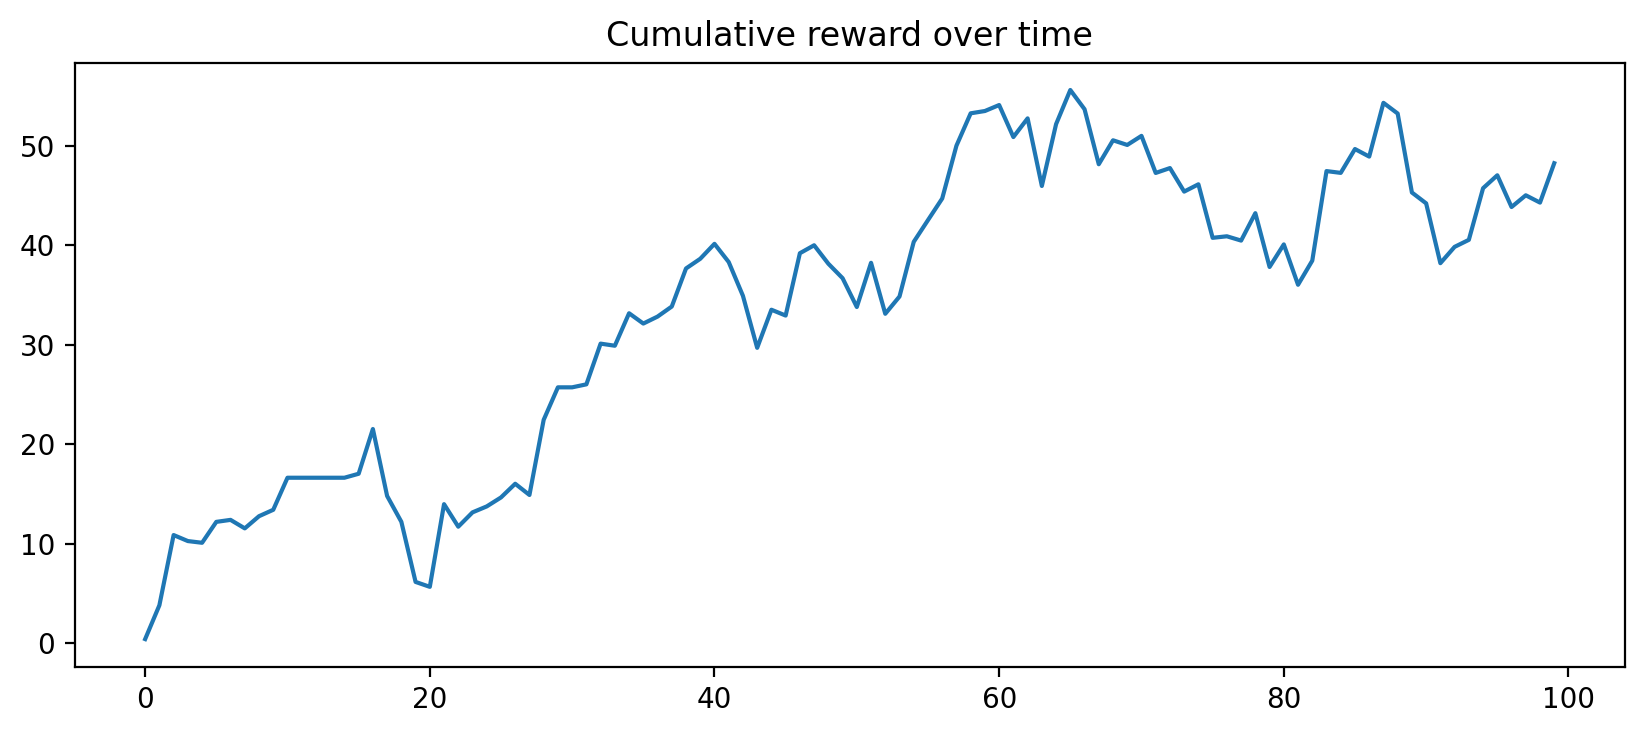

In [14]:
#plot rewards
plt.figure(figsize=(10,4), dpi=200)
plt.plot(rewards)
plt.title('Cumulative reward over time')
plt.show()

In [16]:
rewards[-1:]

[48.22130535964139]

## Q-Learning

In [25]:
env.Q, env.T, env.d

(4, 100, 5)

In [52]:
# Hyperparameters
learning_rate = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
num_steps = 200

# Create the environment
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

# Initialize Q-table
q_table = {(i, j): np.zeros((env.d, env.d)) for i in range(-env.Q, env.Q + 1) for j in range(env.T + 1)}

def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.array(np.unravel_index(np.argmax(q_table[state]), q_table[state].shape))

for episode in range(num_episodes):
    # print(f"episode {episode}")
    env.reset()
    state = env.state()
    done = False
    total_reward = 0

    for step in range(num_steps):
        action = choose_action(state, epsilon)
        next_state, reward, done = env.step(action)
        # print(f"    {step} step: state={state}, epsilon={epsilon}, action={action}, reward={reward}")

        # Update Q-table
        #q_table[state][action] = (1 - learning_rate) * q_table[state][action] + learning_rate * (reward + gamma * (np.max(q_table[next_state])) - q_table[state][action]))
        q_table[state][action] += learning_rate * ((reward + gamma * (np.max(q_table[next_state]))) - q_table[state][action])

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon - epsilon_decay)

    # Print episode results
    if (episode + 1) % 100 == 0:
        print(f'Episode: {episode + 1}, Total Reward: {total_reward}')

Episode: 100, Total Reward: 58.38892834955171
Episode: 200, Total Reward: 111.4560056550197
Episode: 300, Total Reward: 64.8237913818962
Episode: 400, Total Reward: 46.62586435343264
Episode: 500, Total Reward: 25.817979749901014
Episode: 600, Total Reward: 30.110878026741354
Episode: 700, Total Reward: 26.707619908723473
Episode: 800, Total Reward: 22.190580194972668
Episode: 900, Total Reward: 56.363642927591094
Episode: 1000, Total Reward: 23.718273279905254
Episode: 1100, Total Reward: 82.8871218763794
Episode: 1200, Total Reward: -15.152976346972203
Episode: 1300, Total Reward: 82.04559732665577
Episode: 1400, Total Reward: 78.09648101744624
Episode: 1500, Total Reward: 15.559527735203627
Episode: 1600, Total Reward: 16.560912415027104
Episode: 1700, Total Reward: 52.17256507358269
Episode: 1800, Total Reward: 52.95754096696868
Episode: 1900, Total Reward: 1.4194633577737683
Episode: 2000, Total Reward: 57.645748573121914


In [53]:
rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
values = []
disc_reward = 0

env.reset()

while env.t < env.T:
    action = np.array(np.unravel_index(q_table[state].argmax(), q_table[state].shape))
    state = env.state()
    state, action_reward, done = env.step(np.array(action))

    disc_reward += action_reward
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    values.append(env.V_t)

opt_action = np.unravel_index(q_table[(0,0)].argmax(), q_table[(0,0)].shape)
Q_star = q_table[(0,0)][opt_action]

In [54]:
env.render()

--------------------
End of t = 100
Current mid price: 98.51
Current held volume: 0
Current held value: 0.0
Current cash process: 46.96
Current value process: 46.96
--------------------



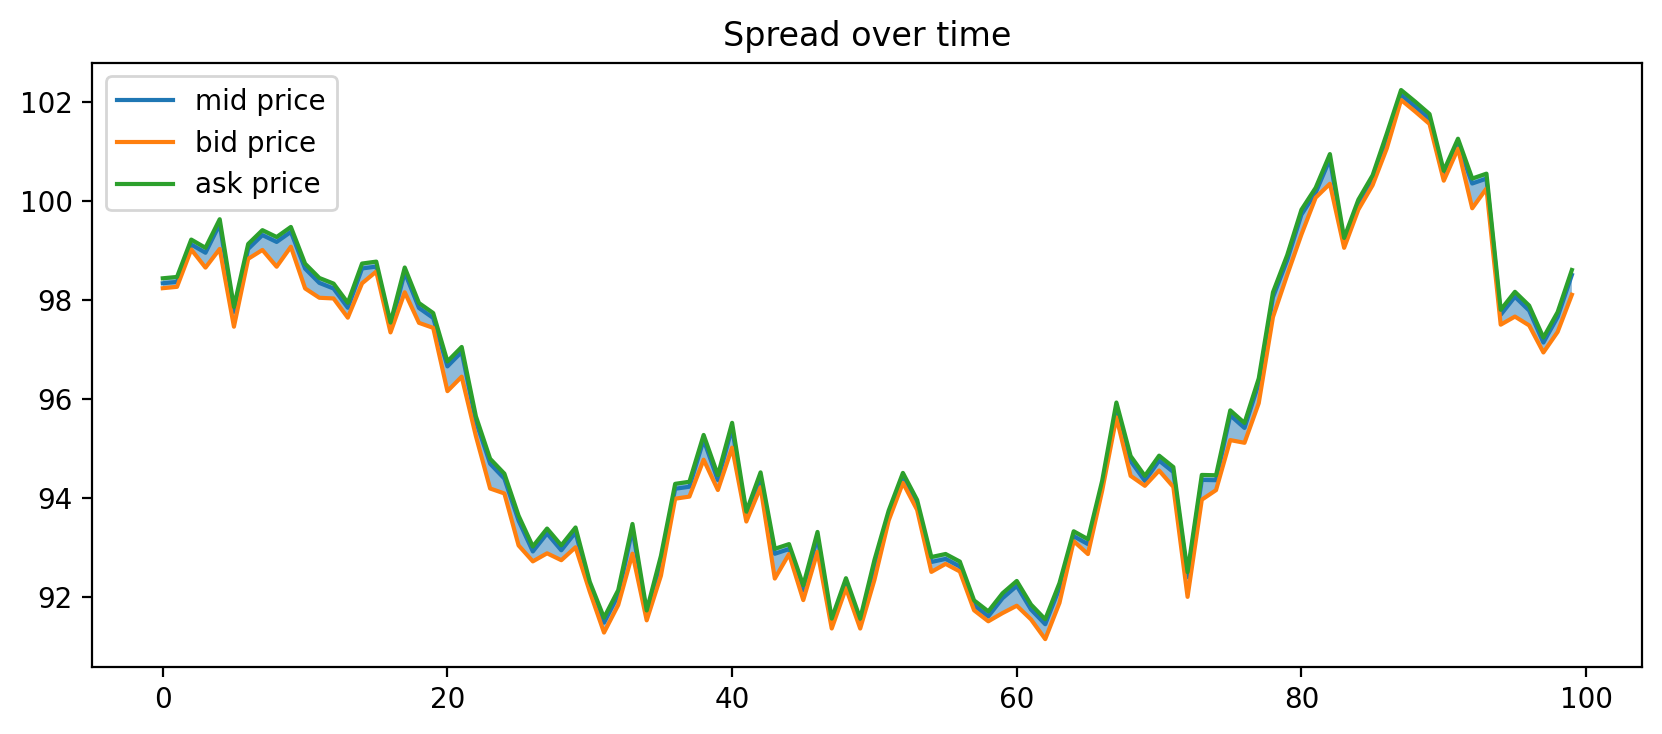

In [55]:
plt.figure(figsize=(10,4), dpi=200)
plt.plot(mid_price, label='mid price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='bid price')
plt.plot(ask_price, label='ask price')
plt.legend()
plt.title('Spread over time')
plt.show()

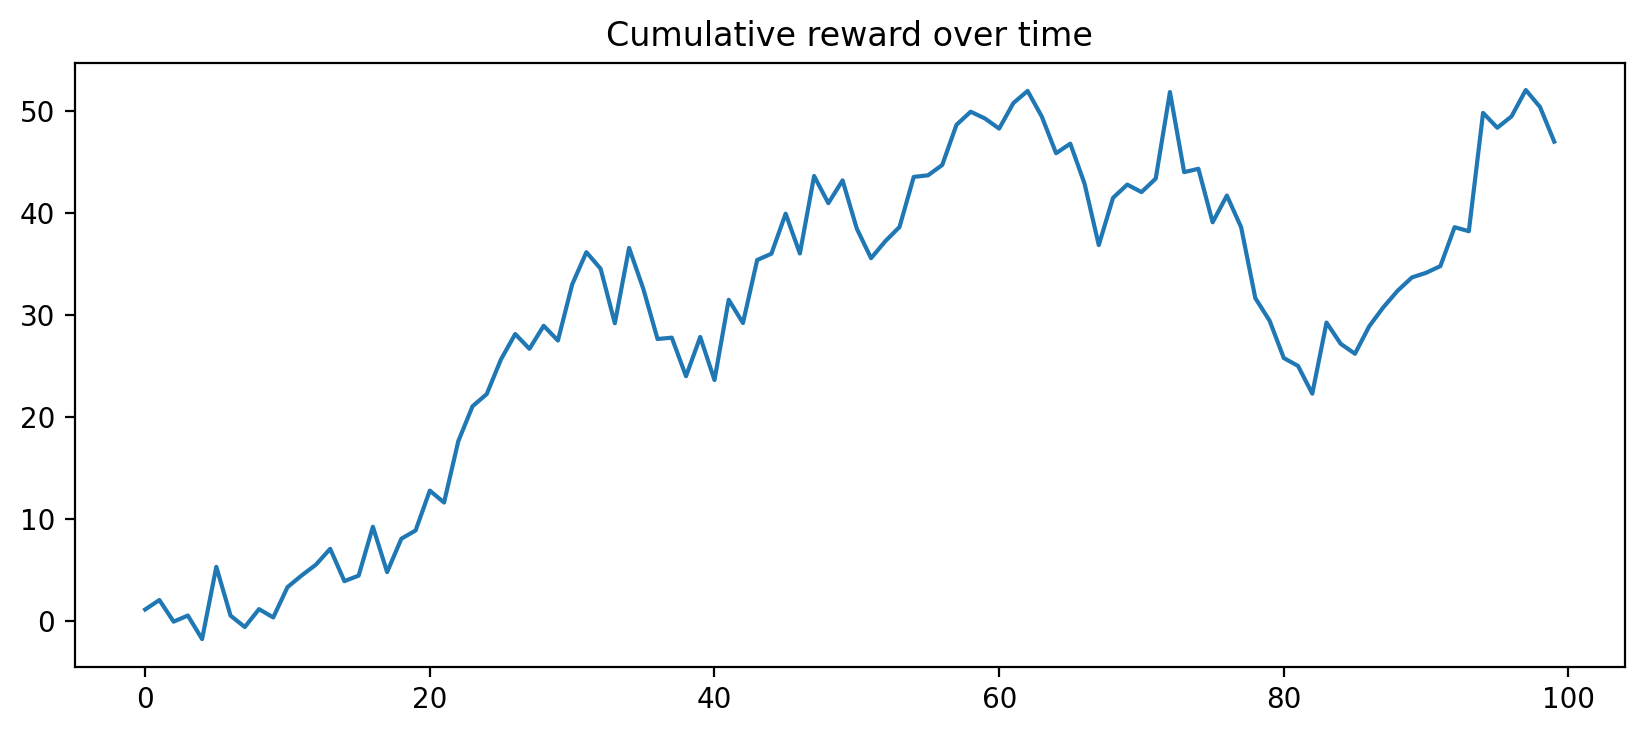

In [56]:
#plot rewards
plt.figure(figsize=(10,4), dpi=200)
plt.plot(rewards)
plt.title('Cumulative reward over time')
plt.show()

In [57]:
rewards[-1]

46.947116709733166

# Multi-armed Bandit

## Explore First Agent

In [42]:
from dataclasses import dataclass
import pandas as pd

@dataclass
class ExploreFirstAgent:

    num_actions_bid: int
    num_actions_ask: int
    max_explore: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        # log
        self.t = 0
        self.log = []
        # action counts n(a)
        self.action_counts_bid = np.zeros(self.num_actions_bid, dtype=int) 
        self.action_counts_ask = np.zeros(self.num_actions_ask, dtype=int) 
        # action value Q(a)
        self.Q_bid = np.zeros(self.num_actions_bid, dtype=float) 
        self.Q_ask = np.zeros(self.num_actions_ask, dtype=float) 

    def update_Q(self, action, reward):
        # update Q action-value given (action, reward)
        # bid
        action_bid = action[0]
        sum_reward = self.Q_bid[action_bid] * self.action_counts_bid[action_bid] + reward # Sum of reward
        self.action_counts_bid[action_bid] = self.action_counts_bid[action_bid] + 1 # Update counts
        self.Q_bid[action_bid] = sum_reward / self.action_counts_bid[action_bid] # Update Q
        # ask
        action_ask = action[1]
        sum_reward = self.Q_ask[action_ask] * self.action_counts_ask[action_ask] + reward # Sum of reward
        self.action_counts_ask[action_ask] = self.action_counts_ask[action_ask] + 1 # Update counts
        self.Q_ask[action_ask] = sum_reward / self.action_counts_ask[action_ask] # Update Q
        # record log
        self.log.append({'t': self.t, 
                         'action_bid':action_bid, 'N_bid':self.action_counts_bid.copy(), 'Q_bid':self.Q_bid.copy(),
                         'action_ask':action_ask, 'N_ask':self.action_counts_ask.copy(), 'Q_ask':self.Q_ask.copy()})

    def get_action(self):
        self.t += 1
        if self.t <= self.max_explore: 
            # Random explore
            selected_action_bid = np.random.randint(0, self.num_actions_bid)
            selected_action_ask = np.random.randint(0, self.num_actions_ask) 
        else:
            # Best exploit
            selected_action_bid = np.argmax(self.Q_bid)
            selected_action_ask = np.argmax(self.Q_ask)

        return [selected_action_bid, selected_action_ask]   
    
    def get_log(self, show=True):
        log_df = pd.DataFrame(self.log)
        if show: display(log_df)
        return log_df

In [53]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_explorefirst = ExploreFirstAgent(num_actions_bid=5, num_actions_ask=5, max_explore=20)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_explorefirst.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_explorefirst.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [54]:
log_df = agent_explorefirst.get_log(show=True)
log_df.to_csv('./output/agent_explorefirst_log.csv', index=False)

,t,action_bid,N_bid,Q_bid,action_ask,N_ask,Q_ask
0,1,1,"[0, 1, 0, 0, 0]","[0.0, 0.29990999999995455, 0.0, 0.0, 0.0]",0,"[1, 0, 0, 0, 0]","[0.29990999999995455, 0.0, 0.0, 0.0, 0.0]"
1,2,2,"[0, 1, 1, 0, 0]","[0.0, 0.29990999999995455, -2.5683078889828783...",0,"[2, 0, 0, 0, 0]","[-1.134198944491462, 0.0, 0.0, 0.0, 0.0]"
2,3,3,"[0, 1, 1, 1, 0]","[0.0, 0.29990999999995455, -2.5683078889828783...",3,"[2, 0, 0, 1, 0]","[-1.134198944491462, 0.0, 0.0, 2.0297631647669..."
3,4,0,"[1, 1, 1, 1, 0]","[-1.0132497051936296, 0.29990999999995455, -2....",3,"[2, 0, 0, 2, 0]","[-1.134198944491462, 0.0, 0.0, 0.5082567297866..."
4,5,4,"[1, 1, 1, 1, 1]","[-1.0132497051936296, 0.29990999999995455, -2....",3,"[2, 0, 0, 3, 0]","[-1.134198944491462, 0.0, 0.0, 1.2275763667860..."
...,...,...,...,...,...,...,...
95,96,2,"[5, 3, 81, 3, 4]","[-1.831461626550443, -1.3061260947313993, 0.63...",0,"[67, 16, 3, 5, 5]","[0.6857078813002526, -0.31953136686828065, -0...."
96,97,2,"[5, 3, 82, 3, 4]","[-1.831461626550443, -1.3061260947313993, 0.69...",0,"[68, 16, 3, 5, 5]","[0.760951161542392, -0.31953136686828065, -0.8..."
97,98,2,"[5, 3, 83, 3, 4]","[-1.831461626550443, -1.3061260947313993, 0.60...",0,"[69, 16, 3, 5, 5]","[0.6561127202249143, -0.31953136686828065, -0...."
98,99,2,"[5, 3, 84, 3, 4]","[-1.831461626550443, -1.3061260947313993, 0.63...",0,"[70, 16, 3, 5, 5]","[0.6918155652842417, -0.31953136686828065, -0...."


In [55]:
env.render()

--------------------
End of t = 100
Current mid price: 92.94
Current held volume: 0
Current held value: 0.0
Current cash process: 30.69
Current value process: 30.69
--------------------



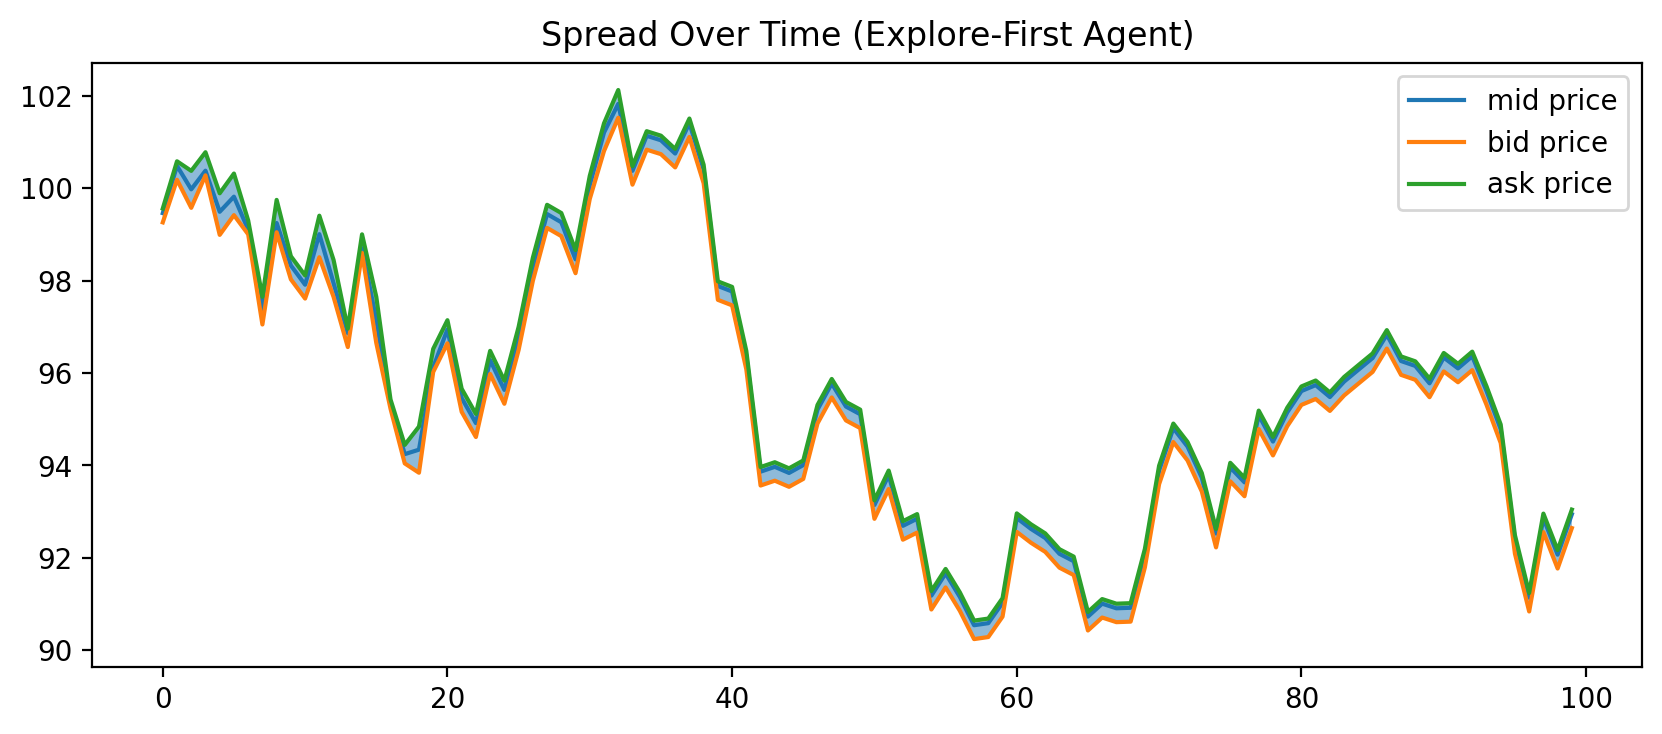

In [56]:
# plot spread
plt.figure(figsize=(10,4), dpi=200)
plt.plot(mid_price, label='mid price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='bid price')
plt.plot(ask_price, label='ask price')
plt.legend()
plt.title('Spread Over Time (Explore-First Agent)')
plt.show()

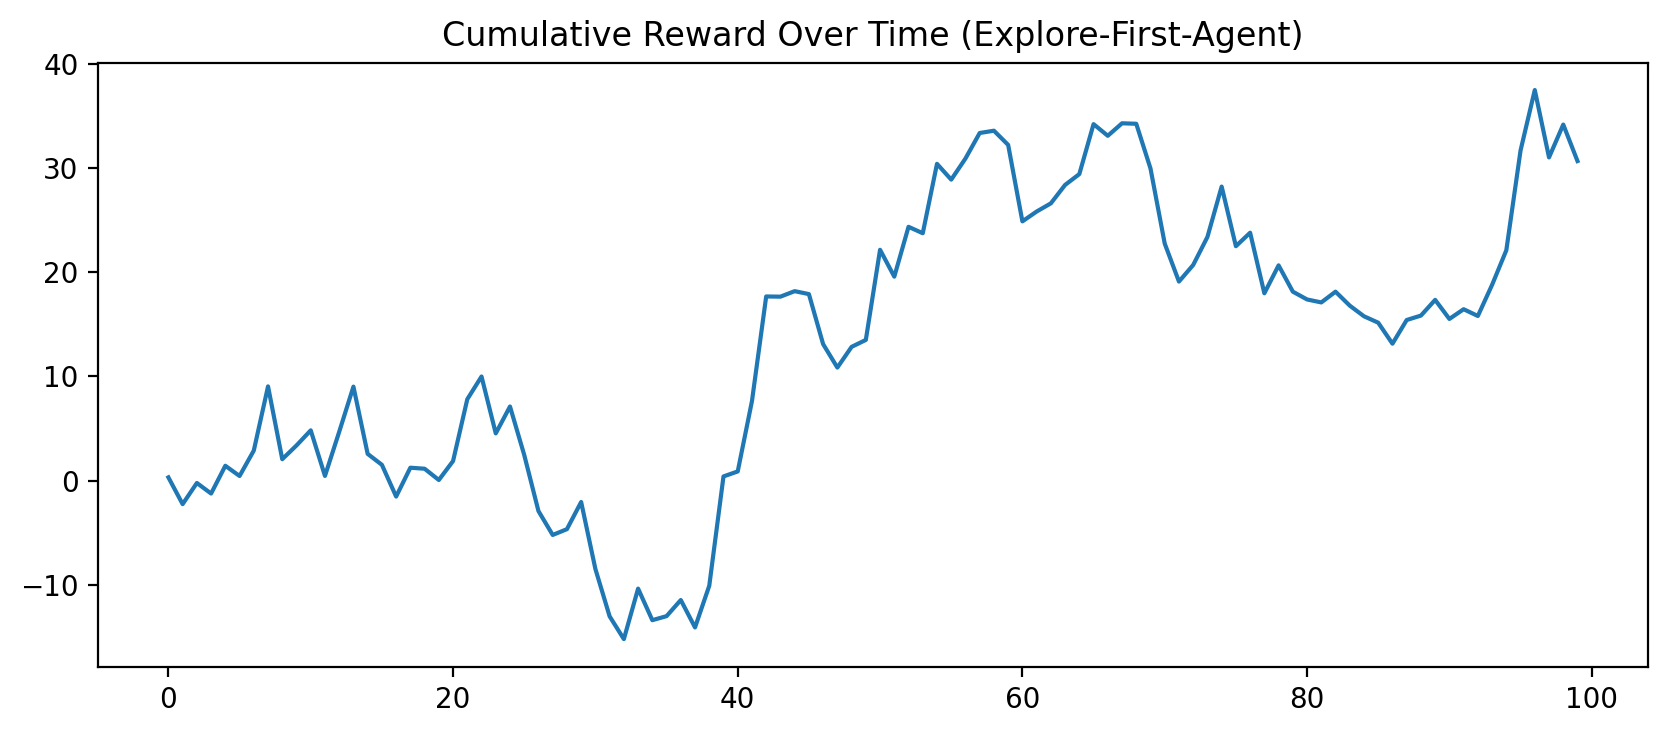

In [57]:
# plot rewards
plt.figure(figsize=(10,4), dpi=200)
plt.plot(rewards)
plt.title('Cumulative Reward Over Time (Explore-First Agent)')
plt.show()

## UCB Agent

In [59]:
@dataclass
class UCBAgent:
    
    num_actions_bid: int
    num_actions_ask: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        # log
        self.t = 0
        self.log = []
        # action counts n(a)
        self.action_counts_bid = np.zeros(self.num_actions_bid, dtype=int) 
        self.action_counts_ask = np.zeros(self.num_actions_ask, dtype=int) 
        # action value Q(a)
        self.Q_bid = np.zeros(self.num_actions_bid, dtype=float) 
        self.Q_ask = np.zeros(self.num_actions_ask, dtype=float) 

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        # bid
        action_bid = action[0]
        sum_reward = self.Q_bid[action_bid] * self.action_counts_bid[action_bid] + reward # Sum of reward
        self.action_counts_bid[action_bid] = self.action_counts_bid[action_bid] + 1 # Update counts
        self.Q_bid[action_bid] = sum_reward / self.action_counts_bid[action_bid] # Update Q
        # ask
        action_ask = action[1]
        sum_reward = self.Q_ask[action_ask] * self.action_counts_ask[action_ask] + reward # Sum of reward
        self.action_counts_ask[action_ask] = self.action_counts_ask[action_ask] + 1 # Update counts
        self.Q_ask[action_ask] = sum_reward / self.action_counts_ask[action_ask] # Update Q
        # record log
        self.log.append({'t': self.t, 
                         'action_bid':action_bid, 'N_bid':self.action_counts_bid.copy(), 'Q_bid':self.Q_bid.copy(),
                         'action_ask':action_ask, 'N_ask':self.action_counts_ask.copy(), 'Q_ask':self.Q_ask.copy()})
   
    def get_action(self):
        self.t += 1
        # Calculate the exploration bonus. To avoid a division by zero, add a small delta=1e-5 to the denominator
        # bid
        exploration_bonus_bid = np.zeros(self.num_actions_bid, dtype=float)
        delta = 1e-5
        for action_bid in range(self.num_actions_bid):
            exploration_bonus_bid[action_bid] = np.sqrt(4 * np.log(self.t) / (self.action_counts_bid[action_bid] + delta))
        Q_explore_bid = self.Q_bid + exploration_bonus_bid
        selected_action_bid = np.argmax(Q_explore_bid)
        # ask
        exploration_bonus_ask = np.zeros(self.num_actions_ask, dtype=float)
        delta = 1e-5
        for action_ask in range(self.num_actions_ask):
            exploration_bonus_ask[action_ask] = np.sqrt(4 * np.log(self.t) / (self.action_counts_ask[action_ask] + delta))
        Q_explore_ask = self.Q_ask + exploration_bonus_ask
        selected_action_ask = np.argmax(Q_explore_ask)

        return [selected_action_bid, selected_action_ask]   
    
    def get_log(self, show=True):
        log_df = pd.DataFrame(self.log)
        if show: display(log_df)
        return log_df

In [60]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_UCB = UCBAgent(num_actions_bid=5, num_actions_ask=5)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_UCB.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_UCB.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [61]:
log_UCB = agent_UCB.get_log(show=True)
log_UCB.to_csv('./output/agent_UCB_log.csv', index=False)

,t,action_bid,N_bid,Q_bid,action_ask,N_ask,Q_ask
0,1,0,"[1, 0, 0, 0, 0]","[0.39999999999997726, 0.0, 0.0, 0.0, 0.0]",0,"[1, 0, 0, 0, 0]","[0.39999999999997726, 0.0, 0.0, 0.0, 0.0]"
1,2,1,"[1, 1, 0, 0, 0]","[0.39999999999997726, 0.3999600000000057, 0.0,...",1,"[1, 1, 0, 0, 0]","[0.39999999999997726, 0.3999600000000057, 0.0,..."
2,3,2,"[1, 1, 1, 0, 0]","[0.39999999999997726, 0.3999600000000057, -1.4...",2,"[1, 1, 1, 0, 0]","[0.39999999999997726, 0.3999600000000057, -1.4..."
3,4,3,"[1, 1, 1, 1, 0]","[0.39999999999997726, 0.3999600000000057, -1.4...",3,"[1, 1, 1, 1, 0]","[0.39999999999997726, 0.3999600000000057, -1.4..."
4,5,4,"[1, 1, 1, 1, 1]","[0.39999999999997726, 0.3999600000000057, -1.4...",4,"[1, 1, 1, 1, 1]","[0.39999999999997726, 0.3999600000000057, -1.4..."
...,...,...,...,...,...,...,...
95,96,4,"[42, 17, 11, 2, 24]","[0.8742748034941089, 0.2354759395544478, 0.184...",4,"[42, 17, 11, 2, 24]","[0.8742748034941089, 0.2354759395544478, 0.184..."
96,97,4,"[42, 17, 11, 2, 25]","[0.8742748034941089, 0.2354759395544478, 0.184...",4,"[42, 17, 11, 2, 25]","[0.8742748034941089, 0.2354759395544478, 0.184..."
97,98,4,"[42, 17, 11, 2, 26]","[0.8742748034941089, 0.2354759395544478, 0.184...",4,"[42, 17, 11, 2, 26]","[0.8742748034941089, 0.2354759395544478, 0.184..."
98,99,4,"[42, 17, 11, 2, 27]","[0.8742748034941089, 0.2354759395544478, 0.184...",4,"[42, 17, 11, 2, 27]","[0.8742748034941089, 0.2354759395544478, 0.184..."


In [62]:
env.render()

--------------------
End of t = 100
Current mid price: 95.9
Current held volume: 0
Current held value: 0.0
Current cash process: 63.27
Current value process: 63.27
--------------------



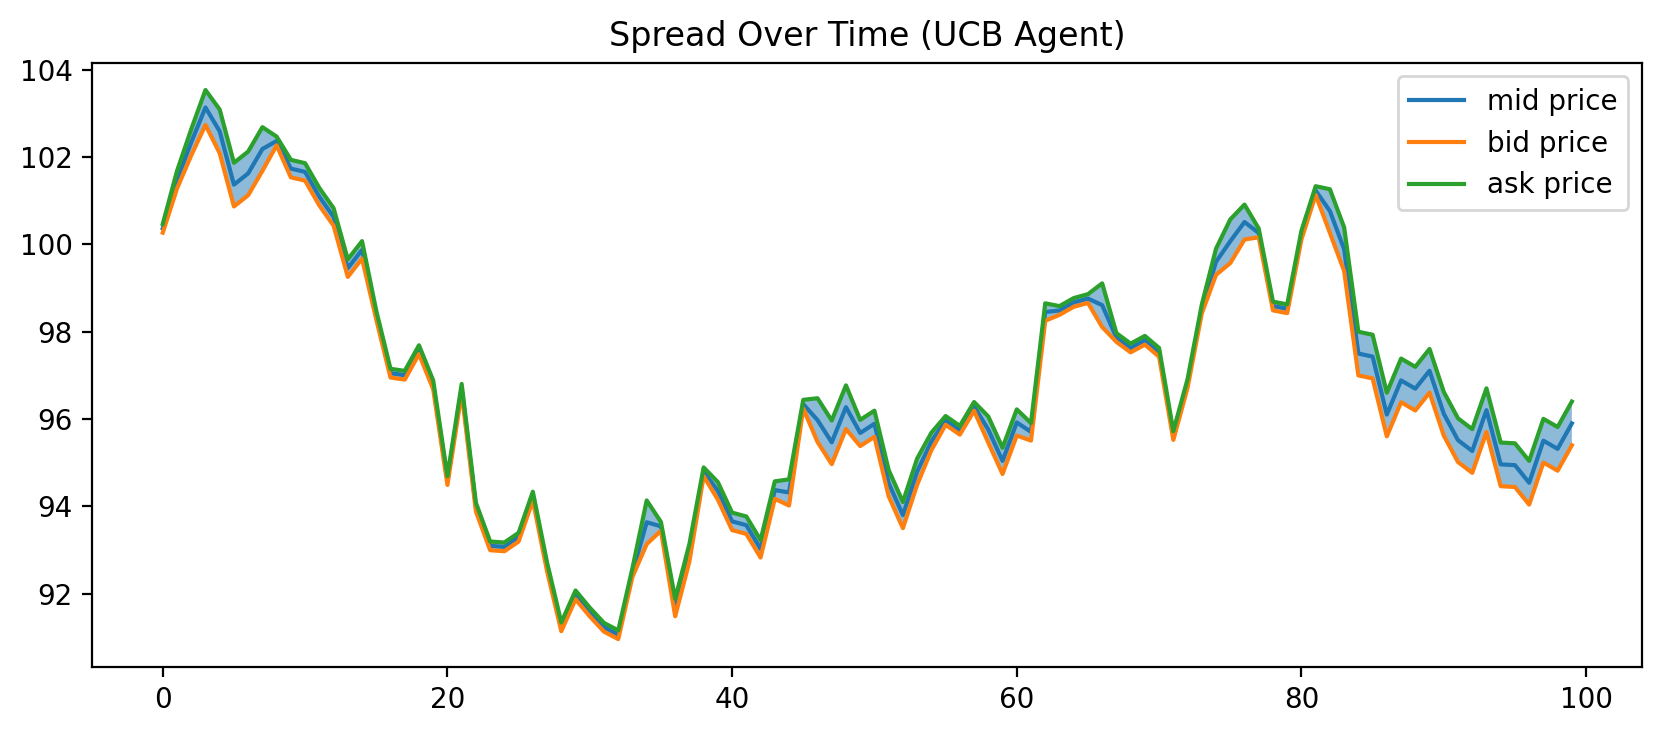

In [63]:
# plot spread
plt.figure(figsize=(10,4), dpi=200)
plt.plot(mid_price, label='mid price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='bid price')
plt.plot(ask_price, label='ask price')
plt.legend()
plt.title('Spread Over Time (UCB Agent)')
plt.show()

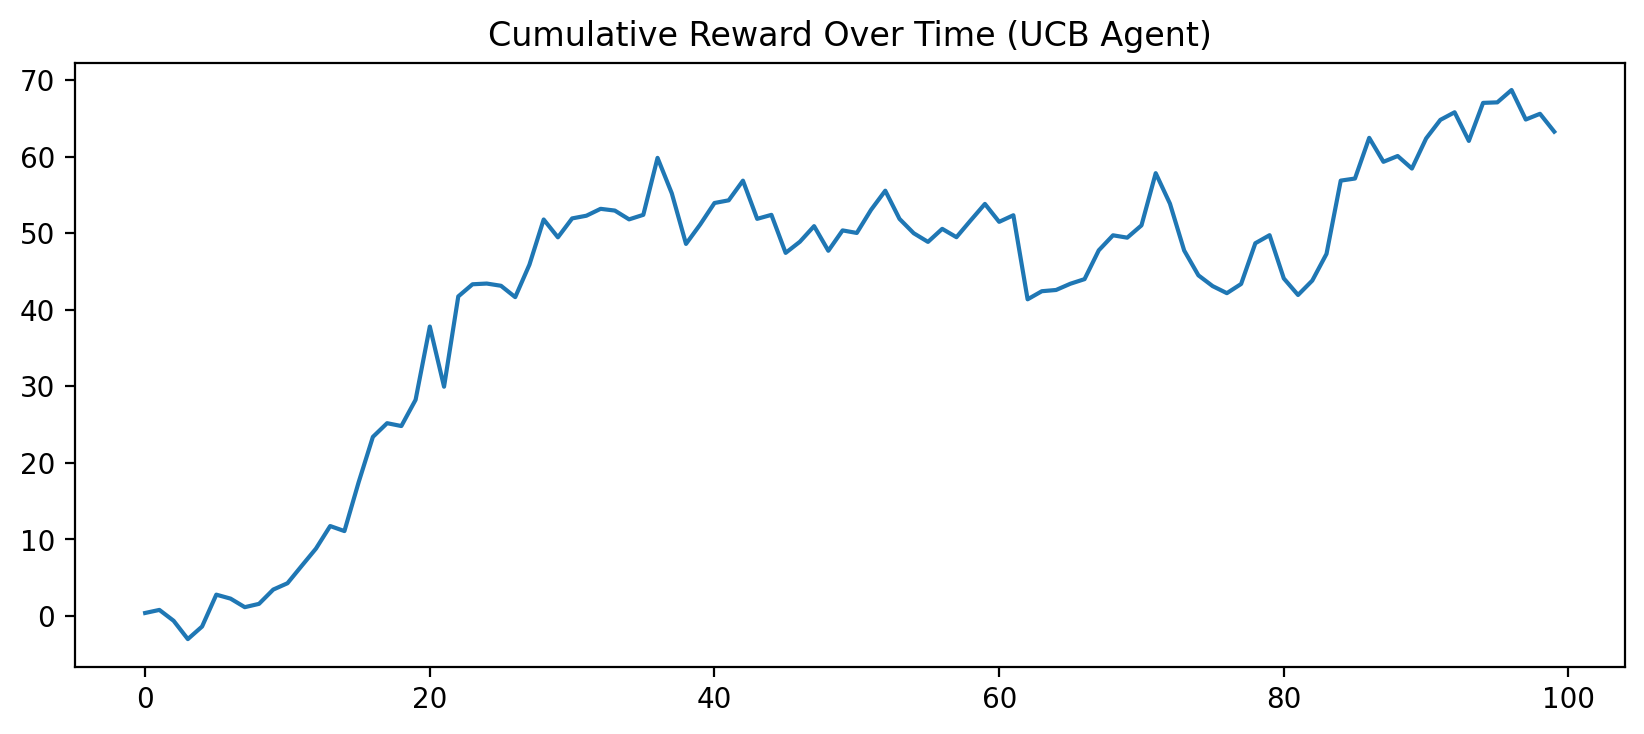

In [64]:
# plot rewards
plt.figure(figsize=(10,4), dpi=200)
plt.plot(rewards)
plt.title('Cumulative Reward Over Time (UCB Agent)')
plt.show()

## Epsilon-Greedy Agent

In [68]:
@dataclass
class EpsilonGreedyAgent:
    
    num_actions_bid: int
    num_actions_ask: int
    epsilon: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        # log
        self.t = 0
        self.log = []
        # action counts n(a)
        self.action_counts_bid = np.zeros(self.num_actions_bid, dtype=int) 
        self.action_counts_ask = np.zeros(self.num_actions_ask, dtype=int) 
        # action value Q(a)
        self.Q_bid = np.zeros(self.num_actions_bid, dtype=float) 
        self.Q_ask = np.zeros(self.num_actions_ask, dtype=float) 

    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        # bid
        action_bid = action[0]
        sum_reward = self.Q_bid[action_bid] * self.action_counts_bid[action_bid] + reward # Sum of reward
        self.action_counts_bid[action_bid] = self.action_counts_bid[action_bid] + 1 # Update counts
        self.Q_bid[action_bid] = sum_reward / self.action_counts_bid[action_bid] # Update Q
        # ask
        action_ask = action[1]
        sum_reward = self.Q_ask[action_ask] * self.action_counts_ask[action_ask] + reward # Sum of reward
        self.action_counts_ask[action_ask] = self.action_counts_ask[action_ask] + 1 # Update counts
        self.Q_ask[action_ask] = sum_reward / self.action_counts_ask[action_ask] # Update Q
        # record log
        self.log.append({'t': self.t, 
                         'action_bid':action_bid, 'N_bid':self.action_counts_bid.copy(), 'Q_bid':self.Q_bid.copy(),
                         'action_ask':action_ask, 'N_ask':self.action_counts_ask.copy(), 'Q_ask':self.Q_ask.copy()})
   
    def get_action(self):
        self.t += 1
        # Epsilon-greedy policy
        if np.random.random() < self.epsilon:
            # Random explore
            selected_action_bid = np.random.randint(0, self.num_actions_bid)
            selected_action_ask = np.random.randint(0, self.num_actions_ask) 
        else:
            # Best exploit
            selected_action_bid = np.argmax(self.Q_bid)
            selected_action_ask = np.argmax(self.Q_ask)

        return [selected_action_bid, selected_action_ask]   
    
    def get_log(self, show=True):
        log_df = pd.DataFrame(self.log)
        if show: display(log_df)
        return log_df

In [73]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
agent_epsilongreedy = EpsilonGreedyAgent(num_actions_bid=5, num_actions_ask=5, epsilon=0.1)

rewards = []
mid_price = []
bid_price = []
ask_price = []
volume = []
cash = []
disc_reward = 0
while env.t < env.T:
    action = agent_epsilongreedy.get_action()
    state, action_reward, done = env.step(np.array(action))
    agent_epsilongreedy.update_Q(action, action_reward)
    disc_reward += action_reward  
    rewards.append(disc_reward)
    mid_price.append(env.mid)
    bid_price.append(env.mm_bid)
    ask_price.append(env.mm_ask)
    volume.append(state[0])
    cash.append(env.X_t)

In [74]:
log_epsilongreedy = agent_epsilongreedy.get_log(show=True)
log_epsilongreedy.to_csv('./output/agent_epsilongreedy_log.csv', index=False)

,t,action_bid,N_bid,Q_bid,action_ask,N_ask,Q_ask
0,1,0,"[1, 0, 0, 0, 0]","[1.4999899999999147, 0.0, 0.0, 0.0, 0.0]",0,"[1, 0, 0, 0, 0]","[1.4999899999999147, 0.0, 0.0, 0.0, 0.0]"
1,2,0,"[2, 0, 0, 0, 0]","[1.5517232187192407, 0.0, 0.0, 0.0, 0.0]",0,"[2, 0, 0, 0, 0]","[1.5517232187192407, 0.0, 0.0, 0.0, 0.0]"
2,3,0,"[3, 0, 0, 0, 0]","[1.3677621458128035, 0.0, 0.0, 0.0, 0.0]",0,"[3, 0, 0, 0, 0]","[1.3677621458128035, 0.0, 0.0, 0.0, 0.0]"
3,4,0,"[4, 0, 0, 0, 0]","[1.533223785453051, 0.0, 0.0, 0.0, 0.0]",0,"[4, 0, 0, 0, 0]","[1.533223785453051, 0.0, 0.0, 0.0, 0.0]"
4,5,0,"[5, 0, 0, 0, 0]","[1.1011127119314463, 0.0, 0.0, 0.0, 0.0]",0,"[5, 0, 0, 0, 0]","[1.1011127119314463, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
95,96,4,"[80, 4, 2, 2, 8]","[0.8218500887754271, 0.273994708667895, -7.361...",0,"[84, 0, 2, 2, 8]","[1.0677725281147954, 0.0, -2.9144671770003527,..."
96,97,4,"[80, 4, 2, 2, 9]","[0.8218500887754271, 0.273994708667895, -7.361...",0,"[85, 0, 2, 2, 8]","[1.0406767370884804, 0.0, -2.9144671770003527,..."
97,98,4,"[80, 4, 2, 2, 10]","[0.8218500887754271, 0.273994708667895, -7.361...",0,"[86, 0, 2, 2, 8]","[1.042409319046085, 0.0, -2.9144671770003527, ..."
98,99,4,"[80, 4, 2, 2, 11]","[0.8218500887754271, 0.273994708667895, -7.361...",0,"[87, 0, 2, 2, 8]","[1.0235833058232582, 0.0, -2.9144671770003527,..."


In [75]:
env.render()

--------------------
End of t = 100
Current mid price: 100.49
Current held volume: 0
Current held value: 0.0
Current cash process: 80.82
Current value process: 80.82
--------------------



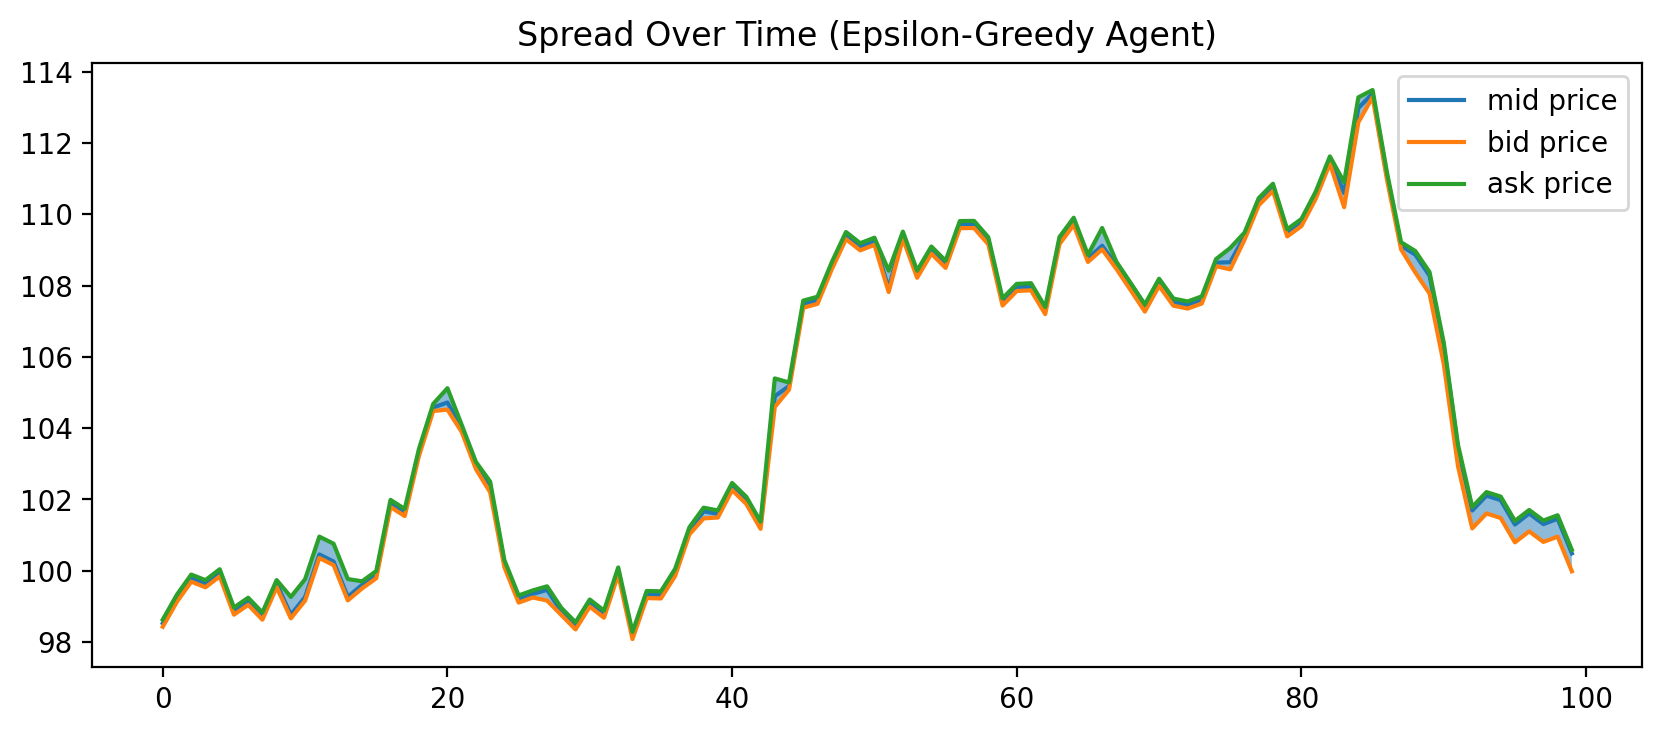

In [76]:
# plot spread
plt.figure(figsize=(10,4), dpi=200)
plt.plot(mid_price, label='mid price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='bid price')
plt.plot(ask_price, label='ask price')
plt.legend()
plt.title('Spread Over Time (Epsilon-Greedy Agent)')
plt.show()

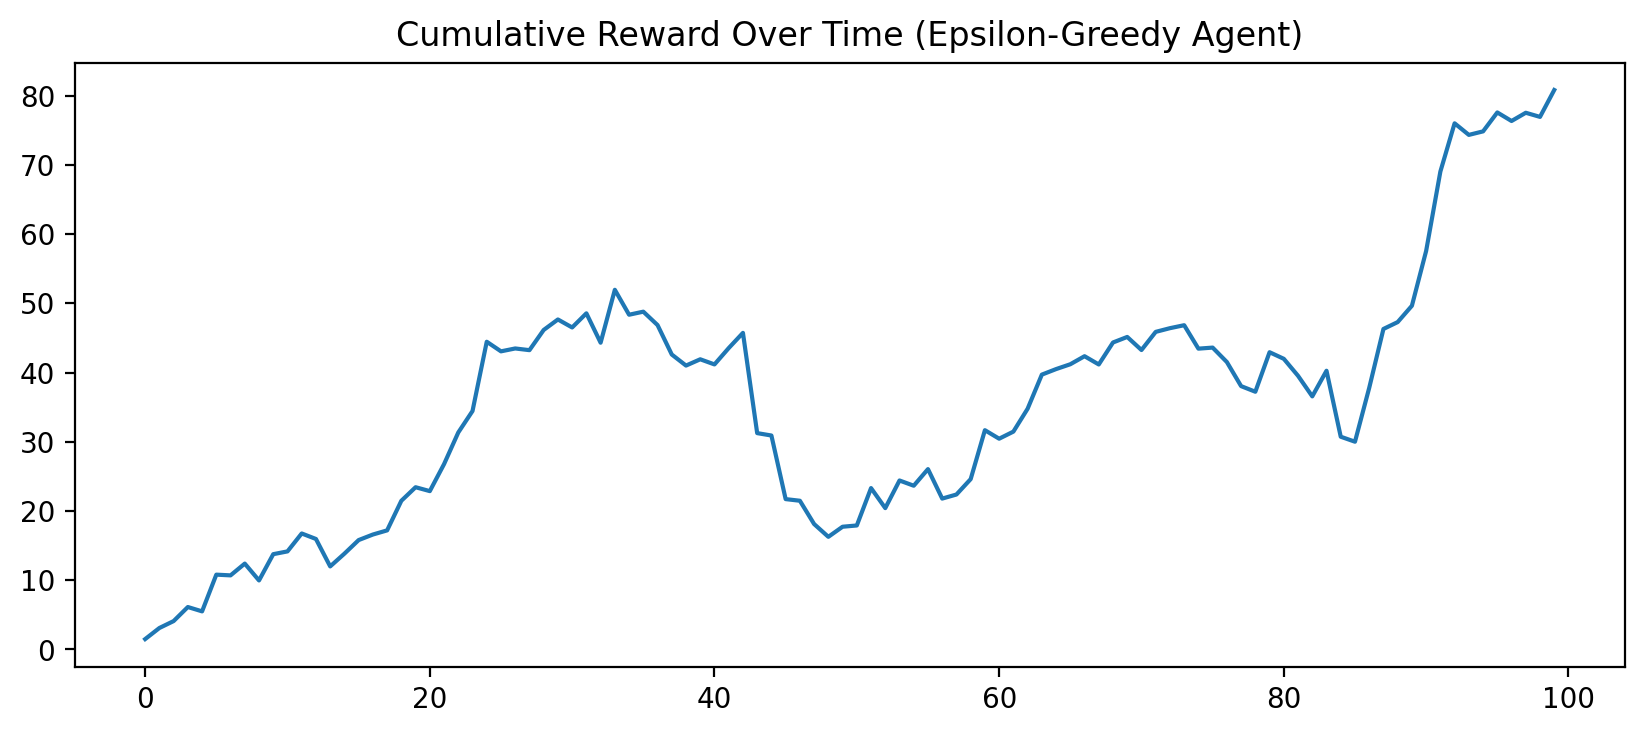

In [77]:
# plot rewards
plt.figure(figsize=(10,4), dpi=200)
plt.plot(rewards)
plt.title('Cumulative Reward Over Time (Epsilon-Greedy Agent)')
plt.show()

# Compare results

In [60]:
# record rewards
reward_random = []

In [61]:
for exp in range(100):

    env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)
    rewards = []
    mid_price = []
    bid_price = []
    ask_price = []
    volume = []
    cash = []
    disc_reward = 0
    while env.t < env.T:
        action = env.action_space.sample()
        state, action_reward, done = env.step(np.array(action))
        disc_reward += action_reward  
        rewards.append(disc_reward)
        mid_price.append(env.mid)
        bid_price.append(env.mm_bid)
        ask_price.append(env.mm_ask)
        volume.append(state[0])
        cash.append(env.X_t)

    reward_random.append(rewards[-1])
    print(f"Random startegy {exp+1}, final reward {rewards[-1]}")

Random startegy 1, final reward 50.180561228414085
Random startegy 2, final reward 19.479914711185387
Random startegy 3, final reward 50.383757588972514
Random startegy 4, final reward -14.867577654272997
Random startegy 5, final reward 39.108859980280116
Random startegy 6, final reward -10.11425494753537
Random startegy 7, final reward 36.2810705133293
Random startegy 8, final reward 72.89455309237653
Random startegy 9, final reward 41.81496509697287
Random startegy 10, final reward 31.882164236408883
Random startegy 11, final reward -2.5662054160838643
Random startegy 12, final reward 90.41174121186027
Random startegy 13, final reward -16.003626605059264
Random startegy 14, final reward 109.22926332137507
Random startegy 15, final reward 49.36866306675233
Random startegy 16, final reward 111.65862059675716
Random startegy 17, final reward 37.33348406212663
Random startegy 18, final reward 44.11678346992395
Random startegy 19, final reward 58.535257885735504
Random startegy 20, final 

In [78]:
# Record rewards with different epsilon_decay
# reward_Q_eps = {}
# reward_Q_eps

In [89]:
reward_Q_tmp = []

for exp in range(1):

    ## Train

    # Hyperparameters
    learning_rate = 0.1
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.3
    num_episodes = 2000
    num_steps = 200

    # Create the environment
    env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

    # Initialize Q-table
    q_table = {(i, j): np.zeros((env.d, env.d)) for i in range(-env.Q, env.Q + 1) for j in range(env.T + 1)}

    for episode in range(num_episodes):
        # print(f"episode {episode}")
        env.reset()
        state = env.state()
        done = False
        total_reward = 0

        for step in range(num_steps):
            action = choose_action(state, epsilon)
            next_state, reward, done = env.step(action)
            # print(f"    {step} step: state={state}, epsilon={epsilon}, action={action}, reward={reward}")

            # Update Q-table
            #q_table[state][action] = (1 - learning_rate) * q_table[state][action] + learning_rate * (reward + gamma * (np.max(q_table[next_state])) - q_table[state][action]))
            q_table[state][action] += learning_rate * ((reward + gamma * (np.max(q_table[next_state]))) - q_table[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon - epsilon_decay)

        # Print episode results
        if (episode + 1) % 1000 == 0:
            print(f'  Episode: {episode + 1}, Total Reward: {total_reward}')

    # Test
    rewards = []
    mid_price = []
    bid_price = []
    ask_price = []
    volume = []
    values = []
    disc_reward = 0

    env.reset()

    while env.t < env.T:
        action = np.array(np.unravel_index(q_table[state].argmax(), q_table[state].shape))
        state = env.state()
        state, action_reward, done = env.step(np.array(action))

        disc_reward += action_reward
        rewards.append(disc_reward)
        mid_price.append(env.mid)
        bid_price.append(env.mm_bid)
        ask_price.append(env.mm_ask)
        volume.append(state[0])
        values.append(env.V_t)

    opt_action = np.unravel_index(q_table[(0,0)].argmax(), q_table[(0,0)].shape)
    Q_star = q_table[(0,0)][opt_action]

    reward_Q_tmp.append(rewards[-1])
    print(f"Q-learning startegy {exp+1}, final reward {rewards[-1]}")

# record rewards
# reward_Q_eps[epsilon_decay] = reward_Q_tmp

  Episode: 1000, Total Reward: -52.34143010402451
  Episode: 2000, Total Reward: -5.82491137489468
Q-learning startegy 1, final reward 70.08194070592175


In [83]:
for key in reward_Q_eps.keys():
    
    print(f"epsilon_decay = {key}, final reward = {np.mean(reward_Q_eps[key])}")

epsilon_decay = 0.995, final reward = 28.867104140663066
epsilon_decay = 0.2, final reward = 29.788505844947586
epsilon_decay = 0.1, final reward = 27.742229644483313
epsilon_decay = 0.01, final reward = 25.148243663889428
epsilon_decay = 0.3, final reward = 62.5798074752647


In [98]:
import pandas as pd

result_df = pd.DataFrame({"Random": reward_random[:10],
                          "Q-learning": reward_Q_eps[0.3]
                          })
result_df.describe()

,Random,Q-learning
count,10.000000,10.000000
mean,31.704401,62.579807
std,27.145963,35.507317
min,-14.867578,15.965942
25%,22.580477,35.053931
50%,37.694965,62.304556
75%,48.089162,80.687017
max,72.894553,137.043167


In [99]:
env.render()

--------------------
End of t = 100
Current mid price: 88.82
Current held volume: 0
Current held value: 0.0
Current cash process: 70.1
Current value process: 70.1
--------------------



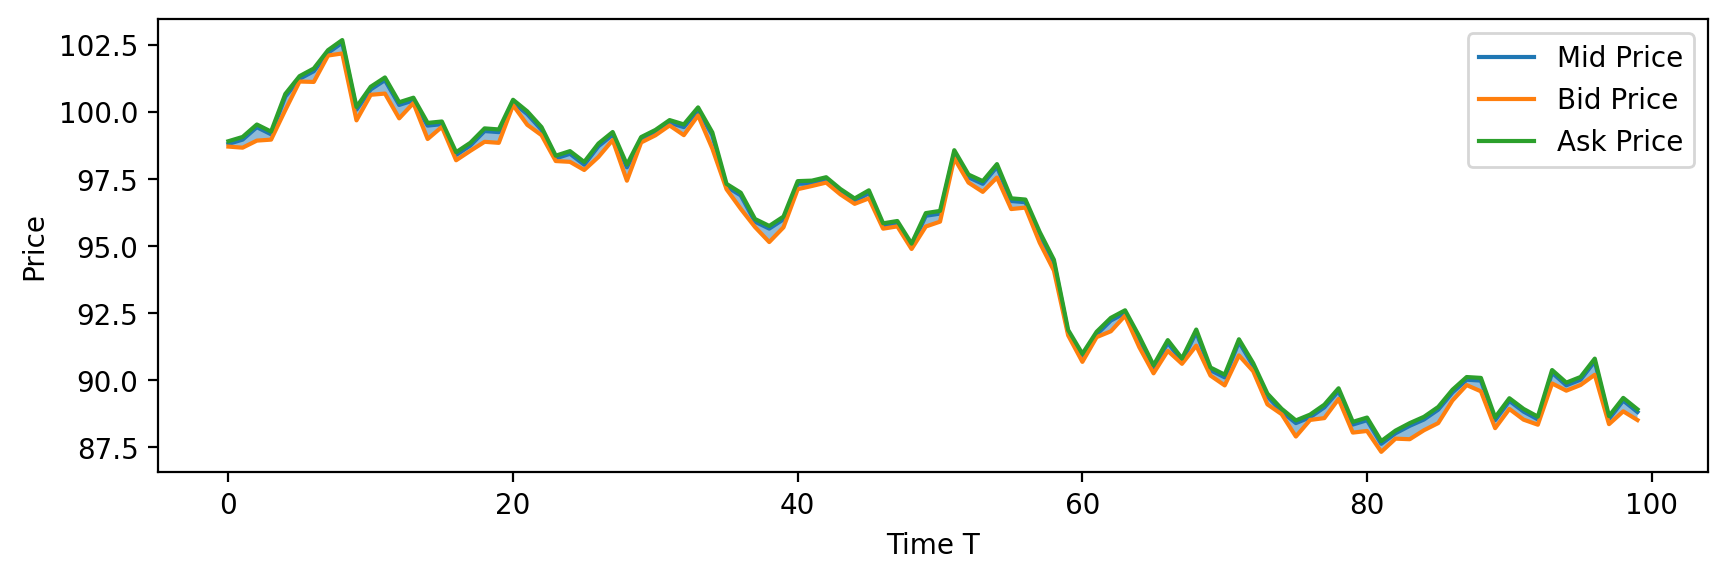

In [100]:
plt.figure(figsize=(10,3), dpi=200)
plt.plot(mid_price, label='Mid Price')
plt.fill_between(range(len(mid_price)), bid_price, ask_price, alpha=0.5)
plt.plot(bid_price, label='Bid Price')
plt.plot(ask_price, label='Ask Price')
plt.xlabel("Time T")
plt.ylabel("Price")
plt.legend()
# plt.title('Spread Over Time (Q-learning)')
plt.show()

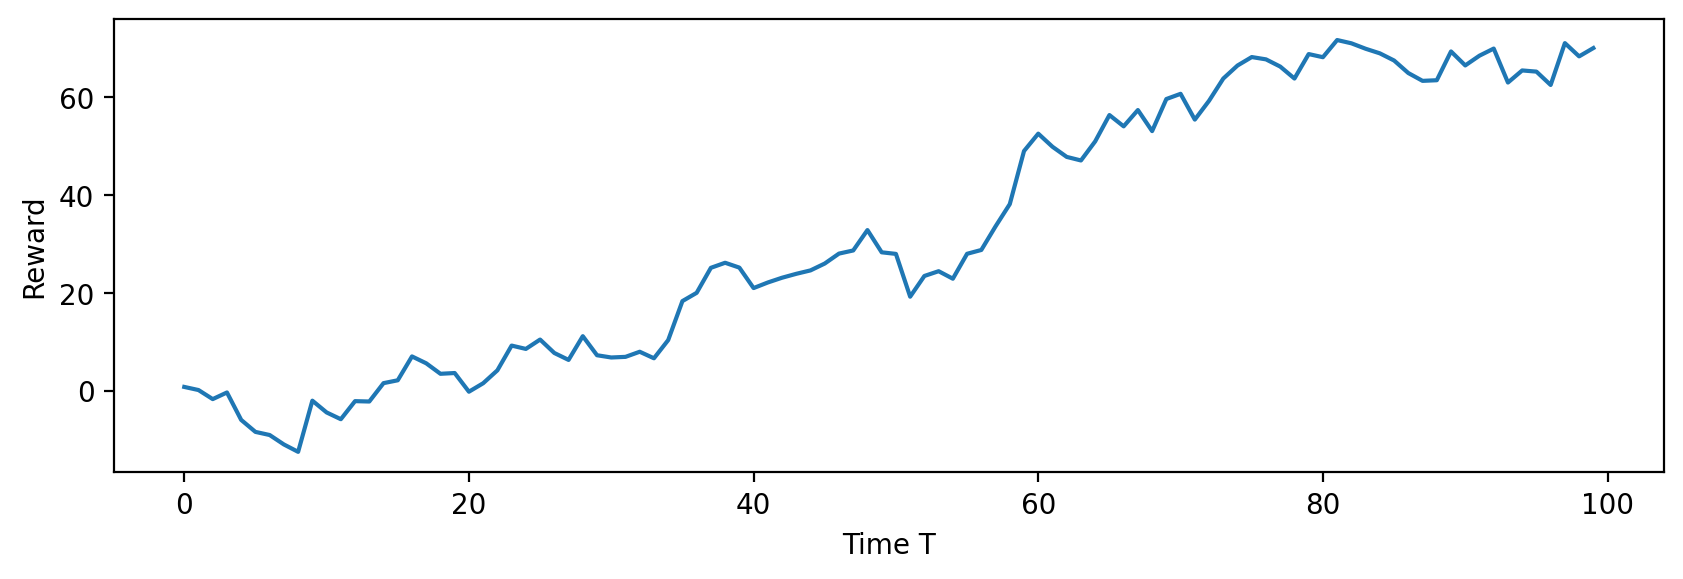

In [101]:
#plot rewards
plt.figure(figsize=(10,3), dpi=200)
plt.plot(rewards)
# plt.title('Cumulative Reward Over Time (Q-learning)')
plt.xlabel("Time T")
plt.ylabel("Reward")
plt.show()